<a href="https://colab.research.google.com/github/ruinhadan/FewShotLearning/blob/main/Conv128_Dynamic_Few_Shot_Visual_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchnet

     |████████████████████████████████| 676 kB 5.7 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
  Created wheel for torchnet: filename=torchnet-0.0.4-py3-none-any.whl size=29742 sha256=8ad4d1d57ae8ddede8f5fadd47a33de35c4c79bfa7253ece813be2c4a572019b
  Stored in directory: /root/.cache/pip/wheels/93/17/b3/86db1d93e9dae198813aa79831b403e4844d67986cf93894b5
  Created wheel for visdom: filename=visdom-0.1.8.9-py3-none-any.whl size=655250 sha256=5a268f1d2a719b7a0e1993d42b6977324b5ce5cb723b00ee401caf94a3b397f6
  Stored in directory: /root/.cache/pip/wheels/2d/d1/9b/cde923274eac9cbb6ff0d8c7c72fe30a3da9095a38fd50bbf1
  Created wheel for torchfile: filename=torchfile-0.1.0-py3-none-any.whl size=5709 sha256=1dbc8f7b069f65e7bd2cb722cc7ec0dac953dc5017a61924d194a51d821d4b7d
  Stored in directory: /root/.cache/pip/wheels/ac/5c/3a/a80e1c65880945c71fd833408cd1e9a8cb7e2f8f37620bb75b
Successfully built torchnet visdom torchfile


# Imports and Data Preprocessing

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import trange
import sklearn.metrics as skm
from sklearn.preprocessing import OneHotEncoder
import torchnet as tnt
import torch.nn.functional as F
import torch.utils.data as data
from PIL import Image
from PIL import ImageEnhance
import math
import random
import pickle
import collections

In [ ]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(0)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
with open("/content/drive/MyDrive/MiniImageNet/MiniImagenet/miniImageNet_category_split_train_phase_train.pickle", 'rb') as f:
      ip_data = pickle.load(f, encoding='latin1')

# Dataset

In [ ]:
class MiniImageNet(data.Dataset):
  def __init__(self, data_base, data_novel=None, phase = 'train'):
    super(MiniImageNet, self).__init__()

    self.data_base = data_base
    self.labels = data_base['labels']
    self.phase = phase
    self.data_novel = data_novel

    if self.phase=='train':
      self.label2ind = self.buildLabelIndex(self.labels) # {0:[0 to 599], 1:[600 to 1199]...}
      self.labelIds = sorted(self.label2ind.keys())      # [0....63]
      self.num_cats = len(self.labelIds)                 # 64
      self.labelIds_base = self.labelIds                 # [0....63]
      self.num_cats_base = len(self.labelIds_base)       # 64
      self.data = self.data_base['data']

    elif self.phase=='val' or self.phase=='test':          
      self.data = np.concatenate([data_base['data'], data_novel['data']], axis=0)
      self.labels = data_base['labels'] + data_novel['labels']

      self.label2ind = self.buildLabelIndex(self.labels)
      self.labelIds = sorted(self.label2ind.keys())
      self.num_cats = len(self.labelIds)

      self.labelIds_base = self.buildLabelIndex(data_base['labels']).keys()
      self.labelIds_novel = self.buildLabelIndex(data_novel['labels']).keys()
      self.num_cats_base = len(self.labelIds_base)
      self.num_cats_novel = len(self.labelIds_novel)
      intersection = set(self.labelIds_base) & set(self.labelIds_novel)
      

    mean_pix = [x/255.0 for x in [120.39586422,  115.59361427, 104.54012653]]
    std_pix = [x/255.0 for x in [70.68188272,  68.27635443,  72.54505529]]
    normalize = transforms.Normalize(mean=mean_pix, std=std_pix)

    self.transform = transforms.Compose([
                    transforms.RandomCrop(84, padding=8),
                    transforms.RandomHorizontalFlip(),
                    lambda x: np.asarray(x),
                    transforms.ToTensor(),
                    normalize
                ])
    
    if phase != 'train':
      self.transform = transforms.Compose([
                    lambda x: np.asarray(x),
                    transforms.ToTensor(),
                    normalize
                ])
      
  def buildLabelIndex(self, labels):
    label2inds = {}
    for idx, label in enumerate(labels):
        if label not in label2inds:
            label2inds[label] = []
        label2inds[label].append(idx)

    return label2inds

  def __getitem__(self, index):
    img, label = self.data[index], self.labels[index]
    img = Image.fromarray(img)
    img = self.transform(img)
    return img, label

  def __len__(self):
    return len(self.data)



# Dataloader

In [ ]:
class FewShotDataloader():
    def __init__(self,
                 dataset,
                 nKnovel=5, # number of novel categories.
                 nKbase=-1, # number of base categories.
                 nExemplars=5, # number of training examples per novel category.
                 nTestNovel=15*5, # number of test examples for all the novel/base categories.
                 nTestBase=15*5,  # 3 * nKnovel for train, 15 * nKnovel for test
                 batch_size=1, # number of training episodes per batch.
                 epoch_size=10, # number of batches per epoch.
                 ):

        self.dataset = dataset
        self.nKnovel = nKnovel
        self.nKbase = nKbase if nKbase >= 0 else 64
        self.phase = self.dataset.phase
        self.nExemplars = nExemplars
        self.nTestNovel = nTestNovel
        self.nTestBase = nTestBase
        self.batch_size = batch_size
        self.epoch_size = epoch_size
        self.is_eval_mode = (self.phase=='test') or (self.phase=='val')

    def sampleImageIdsFrom(self, cat_id, sample_size=5):

        return random.sample(self.dataset.label2ind[cat_id], sample_size)

    def sampleCategories(self, cat_set, sample_size=5):
        
        if cat_set=='base':
            labelIds = self.dataset.labelIds_base
        elif cat_set=='novel':
            labelIds = self.dataset.labelIds_novel

        assert(len(labelIds) >= sample_size)        # In case number of labels % 5 != 0        
        return random.sample(labelIds, sample_size)

    def sample_base_and_novel_categories(self, nKbase, nKnovel):
        
        if self.is_eval_mode:            
            Kbase = sorted(self.sampleCategories('base', nKbase))            
            Knovel = sorted(self.sampleCategories('novel', nKnovel))
        else:            
            cats_ids = self.sampleCategories('base', nKnovel+nKbase)            
            random.shuffle(cats_ids)
            Knovel = sorted(cats_ids[:nKnovel])       # FAKE novel
            Kbase = sorted(cats_ids[nKnovel:])        # Remaining base
            #print("Novel: ",Knovel, "Base: ", Kbase)

        return Kbase, Knovel                          # Class ids

    def sample_test_examples_for_base_categories(self, Kbase, nTestBase):
        
        Tbase = []
        if len(Kbase) > 0:
            #print(len(Kbase), Kbase, nTestBase)
            KbaseIndices = np.random.choice(np.arange(len(Kbase)), size=nTestBase, replace=True)
            #print(KbaseIndices)
            KbaseIndices, NumImagesPerCategory = np.unique(
                KbaseIndices, return_counts=True)
            
            #print(KbaseIndices, NumImagesPerCategory)

            for Kbase_idx, NumImages in zip(KbaseIndices, NumImagesPerCategory):
                imd_ids = self.sampleImageIdsFrom(
                    Kbase[Kbase_idx], sample_size=NumImages)
                Tbase += [(img_id, Kbase_idx) for img_id in imd_ids]
            
            #print(len(Tbase))

        assert(len(Tbase) == nTestBase)

        return Tbase

    def sample_train_and_test_examples_for_novel_categories(
            self, Knovel, nTestNovel, nExemplars, nKbase):
        

        if len(Knovel) == 0:
            return [], []

        nKnovel = len(Knovel)
        Tnovel = []
        Exemplars = []
        assert((nTestNovel % nKnovel) == 0)
        nEvalExamplesPerClass = nTestNovel // nKnovel

        for Knovel_idx in range(len(Knovel)):
            imd_ids = self.sampleImageIdsFrom(
                Knovel[Knovel_idx],
                sample_size=(nEvalExamplesPerClass + nExemplars))

            imds_tnovel = imd_ids[:nEvalExamplesPerClass]
            imds_ememplars = imd_ids[nEvalExamplesPerClass:]

            Tnovel += [(img_id, nKbase + Knovel_idx) for img_id in imds_tnovel]
            Exemplars += [(img_id, nKbase + Knovel_idx) for img_id in imds_ememplars]
        assert(len(Tnovel) == nTestNovel)
        assert(len(Exemplars) == len(Knovel) * nExemplars)
        random.shuffle(Exemplars)

        return Tnovel, Exemplars

    def sample_episode(self):
       
        nKnovel = self.nKnovel
        nKbase = self.nKbase
        nTestNovel = self.nTestNovel
        nTestBase = self.nTestBase
        nExemplars = self.nExemplars

        Kbase, Knovel = self.sample_base_and_novel_categories(nKbase, nKnovel)
        Tbase = self.sample_test_examples_for_base_categories(Kbase, nTestBase)
        #print(len(Tbase))
        Tnovel, Exemplars = self.sample_train_and_test_examples_for_novel_categories(
            Knovel, nTestNovel, nExemplars, nKbase)

       
        Test = Tbase + Tnovel
        random.shuffle(Test)
        Kall = Kbase + Knovel

        return Exemplars, Test, Kall, nKbase              # Exemplars - 5-way 5-shot, Test - 15 + 15, Kall - shuffle[0...63], nKbase - 59

    def createExamplesTensorData(self, examples):
        
        images = torch.stack(
            [self.dataset[img_idx][0] for img_idx, _ in examples], dim=0)
        labels = torch.LongTensor([label for _, label in examples])
        return images, labels

    def get_iterator(self, epoch=0):
        rand_seed = epoch
        random.seed(rand_seed)
        np.random.seed(rand_seed)
        def load_function(iter_idx):
            Exemplars, Test, Kall, nKbase = self.sample_episode()
            Xt, Yt = self.createExamplesTensorData(Test)
            Kall = torch.LongTensor(Kall)
            if len(Exemplars) > 0:
                Xe, Ye = self.createExamplesTensorData(Exemplars)
                return Xe, Ye, Xt, Yt, Kall, nKbase
            else:
                return Xt, Yt, Kall, nKbase

        tnt_dataset = tnt.dataset.ListDataset(
            elem_list=range(self.epoch_size), load=load_function)
        data_loader = tnt_dataset.parallel(
            batch_size=self.batch_size,
            # num_workers=(0 if self.is_eval_mode else self.num_workers),
            shuffle=(False if self.is_eval_mode else True))

        return data_loader

    def __call__(self, epoch=0):
        return self.get_iterator(epoch)

    def __len__(self):
        return (self.epoch_size / self.batch_size)


Sample episode
```
torch.Size([8, 25, 3, 84, 84]) - Xe
torch.Size([8, 25]) - Ye
torch.Size([8, 30, 3, 84, 84]) - Xt
torch.Size([8, 30]) - Yt
torch.Size([8, 64]) - Kall
torch.Size([8]) - nKbase
```

# Feature Extractor & Classifier

In [ ]:
class C128F(nn.Module):
    def __init__(self, x_dim=3):
        super(C128F, self).__init__()
        self.encoder = nn.Sequential(
            self.conv_block(x_dim, 64),
            self.conv_block(64, 64),
            self.conv_block(64, 128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )


    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)

In [ ]:
class FeatExemplarAvgBlock(nn.Module):
    def __init__(self, nFeat):
        super(FeatExemplarAvgBlock, self).__init__()

    def forward(self, features_train, labels_train):
        labels_train_transposed = labels_train.transpose(1,2)
        weight_novel = torch.bmm(labels_train_transposed, features_train)
        weight_novel = weight_novel.div(
            labels_train_transposed.sum(dim=2, keepdim=True).expand_as(weight_novel))
        return weight_novel

In [ ]:
class LinearDiag(nn.Module):
    def __init__(self, num_features, bias=False):
        super(LinearDiag, self).__init__()
        weight = torch.FloatTensor(num_features).fill_(1).to(device) # initialize to the identity transform
        self.weight = nn.Parameter(weight, requires_grad=True).to(device)

        if bias:
            bias = torch.FloatTensor(num_features).fill_(0).to(device)
            self.bias = nn.Parameter(bias, requires_grad=True).to(device)
        else:
            self.register_parameter('bias', None)

    def forward(self, X):
        assert(X.dim()==2 and X.size(1)==self.weight.size(0))
        out = X * self.weight.expand_as(X)
        if self.bias is not None:
            out = out + self.bias.expand_as(out)
        return out

In [ ]:
class AttentionBasedBlock(nn.Module):
    def __init__(self, nFeat, nK, scale_att=10.0):
        super(AttentionBasedBlock, self).__init__()
        self.nFeat = nFeat
        self.queryLayer = nn.Linear(nFeat, nFeat)
        self.queryLayer.weight.data.copy_(torch.eye(nFeat, nFeat) + torch.randn(nFeat, nFeat)*0.001)
        self.queryLayer.bias.data.zero_()
        scale_att = torch.FloatTensor(1).fill_(scale_att).to(device)
        self.scale_att = nn.Parameter(scale_att, requires_grad=True).to(device)
        wkeys = torch.FloatTensor(nK, nFeat).normal_(0.0, np.sqrt(2.0/nFeat)).to(device)
        self.wkeys = nn.Parameter(wkeys, requires_grad=True).to(device)


    def forward(self, features_train, labels_train, weight_base, Kbase):
        batch_size, num_train_examples, num_features = features_train.size()
        nKbase = weight_base.size(1) # [batch_size x nKbase x num_features]
        labels_train_transposed = labels_train.transpose(1,2)
        nKnovel = labels_train_transposed.size(1) # [batch_size x nKnovel x num_train_examples]

        features_train = features_train.view(
            batch_size*num_train_examples, num_features)
        Qe = self.queryLayer(features_train)
        Qe = Qe.view(batch_size, num_train_examples, self.nFeat)
        Qe = F.normalize(Qe, p=2, dim=Qe.dim()-1, eps=1e-12)

        wkeys = self.wkeys[Kbase.reshape(-1)]
        wkeys = F.normalize(wkeys, p=2, dim=wkeys.dim()-1, eps=1e-12)
        wkeys = wkeys.view(batch_size, nKbase, self.nFeat).transpose(1,2)

        
        AttentionCoeficients = self.scale_att * torch.bmm(Qe, wkeys)
        AttentionCoeficients = F.softmax(AttentionCoeficients.view(batch_size*num_train_examples, nKbase))
        AttentionCoeficients = AttentionCoeficients.view(batch_size, num_train_examples, nKbase)

        
        weight_novel = torch.bmm(AttentionCoeficients, weight_base)
        weight_novel = torch.bmm(labels_train_transposed, weight_novel)
        weight_novel = weight_novel.div(labels_train_transposed.sum(dim=2, keepdim=True).expand_as(weight_novel))

        return weight_novel

In [ ]:
class Classifier(nn.Module):
  def __init__(self, gen_type=None):
    super(Classifier, self).__init__()

    self.nFeat = 128*5*5 # 3200
    self.nKall = 64
    self.nKbase = 64 if gen_type is None else 59
    self.nKnovel = 5
    self.gen_type = gen_type

    weight_base = torch.FloatTensor(self.nKall, self.nFeat).normal_(0.0, np.sqrt(2.0/self.nFeat)).to(device) # 64 * 3200
    self.weight_base = nn.Parameter(weight_base, requires_grad=True).to(device)
    bias = torch.FloatTensor(1).fill_(0).to(device)
    self.bias = nn.Parameter(bias, requires_grad=True).to(device) # torch.tensor([0])
    scale_cls = torch.FloatTensor(1).fill_(10.0).to(device)
    self.scale_cls = nn.Parameter(scale_cls, requires_grad=True).to(device)

    if self.gen_type=='feat_avg':

      self.favgblock = FeatExemplarAvgBlock(self.nFeat)
      self.wnLayerFavg = LinearDiag(self.nFeat, bias=True)
    
    elif self.gen_type=='attn':

      self.favgblock = FeatExemplarAvgBlock(self.nFeat)
      self.attblock = AttentionBasedBlock(self.nFeat, self.nKall)
      self.wnLayerFavg = LinearDiag(self.nFeat)
      self.wnLayerWatt = LinearDiag(self.nFeat)
    
  def get_classification_weights(self, features_train=None, labels_train=None, Kbase_ids=None, batch_size=8):
    Kbase_ids = np.asarray([[i for i in range(64)] for j in range(batch_size)]) if Kbase_ids is None else Kbase_ids
    weight_base = self.weight_base[Kbase_ids.reshape(-1)]
    weight_base = weight_base.view(batch_size, self.nKbase, -1)

    if features_train is None:
      return weight_base
    
    _, num_train_examples, num_channels = features_train.size()
    features_train = F.normalize(features_train, p=2, dim=features_train.dim()-1, eps=1e-12)
    if self.gen_type == 'feat_avg':
      weight_novel_avg = self.favgblock(features_train, labels_train)
      weight_novel = self.wnLayerFavg(weight_novel_avg.view(batch_size * self.nKnovel, num_channels))
      weight_novel = weight_novel.view(batch_size, self.nKnovel, num_channels)
    
    elif self.gen_type=='attn':
      weight_novel_avg = self.favgblock(features_train, labels_train)
      weight_novel_avg = self.wnLayerFavg(weight_novel_avg.view(batch_size * self.nKnovel, num_channels))
      weight_base_tmp = F.normalize(weight_base, p=2, dim=weight_base.dim()-1, eps=1e-12)

      weight_novel_att = self.attblock(features_train, labels_train, weight_base_tmp, Kbase_ids)
      weight_novel_att = self.wnLayerWatt(weight_novel_att.view(batch_size * self.nKnovel, num_channels)      )
      weight_novel = weight_novel_avg + weight_novel_att
      weight_novel = weight_novel.view(batch_size, self.nKnovel, num_channels)
    
    w = torch.cat((weight_base,weight_novel),1)
    return w   
    

  def apply_classification_weights(self, features, cls_weights):
    features = F.normalize(features, p=2, dim=features.dim()-1, eps=1e-12) # 8 * 1 * 3200
    cls_weights = F.normalize(cls_weights, p=2, dim=cls_weights.dim()-1, eps=1e-12) # 8 * 64 * 3200    
    cls_scores = self.scale_cls * torch.baddbmm(self.bias.view(1, 1, 1),features, cls_weights.transpose(1,2)) # transpose to 8 * 3200 * 64
    # 8 * [1 * 3200 x 3200 * 64 => 1 * 64 + bias]
    return cls_scores # 8 * 1 * 64

  def forward(self, features_test = None, features_train = None, labels_train=None, Kbase_ids=None, batch_size=8): 
    self.nKbase = len(Kbase_ids[0]) if Kbase_ids is not None else 64
    cls_weights = self.get_classification_weights(features_train, labels_train, Kbase_ids, batch_size)
    features_test = features_test.view(batch_size, 1 if features_train is None else len(features_test[0]), self.nFeat) 
    cls_scores = self.apply_classification_weights(features_test, cls_weights)
    
    return cls_scores
    

# Train Stage 1 - Training the feature extractor & base class classifier

In [ ]:
BATCH_SIZE = 8
EPOCHS = 10

In [ ]:
# input_data = MiniImageNet(ip_data)
# dataloader = torch.utils.data.DataLoader(input_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
input_data = MiniImageNet(ip_data)

In [ ]:
dataloader = FewShotDataloader(
    input_data, 
    nKnovel=0, 
    nKbase=64, 
    nExemplars=0, 
    nTestNovel=0, 
    nTestBase=32, 
    batch_size=8, 
    epoch_size=8000
)

In [ ]:
feature_extractor = C128F().to(device)
base_classifier = Classifier().to(device)

In [ ]:
feature_extractor.load_state_dict(torch.load("/content/drive/MyDrive/MiniImageNet/MiniImagenet/feat_Paper.pth"))
base_classifier.load_state_dict(torch.load("/content/drive/MyDrive/MiniImageNet/MiniImagenet/clas_Paper.pth"))

<All keys matched successfully>

In [ ]:
# opt_feat = optim.Adam(feature_extractor.parameters(), lr=0.1, weight_decay=1e-9)
# opt_clas = optim.Adam(base_classifier.parameters(), lr=0.1, weight_decay=1e-9)
# lossfn = nn.CrossEntropyLoss()

In [ ]:
opt_feat = optim.SGD(feature_extractor.parameters(), lr=0.00024, weight_decay=5e-4, momentum=0.9, nesterov=True)
opt_clas = optim.SGD(base_classifier.parameters(), lr=0.00024, weight_decay=5e-4, momentum=0.9, nesterov=True)
lossfn = nn.CrossEntropyLoss()

In [ ]:
feature_extractor.train()

C128F(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(

In [ ]:
loss_per_epoch = []
for epoch in trange(EPOCHS):
  sum_of_loss = 0.0
  for Xt,Yt,Kall,nKbase in dataloader():
    Xt = Xt.to(device).view(8*32, 3, 84, 84)
    Yt = torch.tensor(Yt).to(device).view(8*32)
    #print(Yt, Yt.size())
    opt_feat.zero_grad()
    opt_clas.zero_grad()
    output = base_classifier(feature_extractor(Xt), batch_size=8*32)
    loss = lossfn(output.view(8*32, 64), Yt)
    sum_of_loss += loss.detach()
    loss.backward()
    opt_feat.step()
    opt_clas.step()
    del Xt, Yt, output
  print("Epoch #"+str(epoch)+" Loss:"+str(sum_of_loss.item()/1000))
  loss_per_epoch.append(sum_of_loss/1000)
  with open('/content/drive/MyDrive/MiniImageNet/loss_t1_Paper.txt', 'a') as f:
    f.write('\n'+str(sum_of_loss.item()/1000))
    
# plt.plot(loss_per_epoch)
# plt.xlabel('Epochs')
# plt.ylabel('Cross Entropy Loss')
# plt.show()

 10%|█         | 1/10 [06:49<1:01:28, 409.80s/it]

Epoch #0 Loss:0.45599050903320315


 20%|██        | 2/10 [13:33<54:10, 406.25s/it]  

Epoch #1 Loss:0.4539679260253906


 30%|███       | 3/10 [20:22<47:32, 407.55s/it]

Epoch #2 Loss:0.452847900390625


 40%|████      | 4/10 [27:12<40:50, 408.41s/it]

Epoch #3 Loss:0.4519698486328125


 50%|█████     | 5/10 [33:57<33:56, 407.21s/it]

Epoch #4 Loss:0.45114337158203127


 60%|██████    | 6/10 [40:42<27:05, 406.43s/it]

Epoch #5 Loss:0.450466064453125


 70%|███████   | 7/10 [47:26<20:17, 405.75s/it]

Epoch #6 Loss:0.45155978393554685


 80%|████████  | 8/10 [54:10<13:30, 405.25s/it]

Epoch #7 Loss:0.4502254943847656
Epoch #8 Loss:0.45212460327148435


100%|██████████| 10/10 [1:07:39<00:00, 405.94s/it]

Epoch #9 Loss:0.44872283935546875


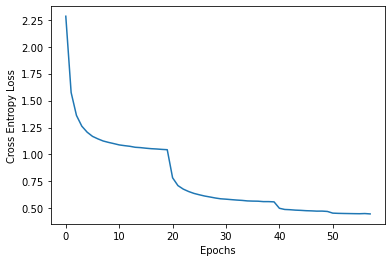

In [ ]:
with open('/content/drive/MyDrive/MiniImageNet/loss_t1_Paper.txt', 'r') as f:
  loss_per_epoch = f.readlines()

loss_per_epoch = [float(x) for x in loss_per_epoch]

plt.plot(loss_per_epoch)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()

# Saving models' weights

In [ ]:
torch.save(feature_extractor.state_dict(), "/content/drive/MyDrive/MiniImageNet/MiniImagenet/feat_Paper.pth")
torch.save(base_classifier.state_dict(), "/content/drive/MyDrive/MiniImageNet/MiniImagenet/clas_Paper.pth")
torch.save(base_classifier.state_dict()['weight_base'], "/content/drive/MyDrive/MiniImageNet/MiniImagenet/wts_base_Paper.pt")

# Evaluating Feature Extractor

In [ ]:
feature_extractor.load_state_dict(torch.load("/content/drive/MyDrive/MiniImageNet/MiniImagenet/feat_0.00001_200.pth"))
base_classifier.load_state_dict(torch.load("/content/drive/MyDrive/MiniImageNet/MiniImagenet/clas_0.00001_200.pth"))

<All keys matched successfully>

In [ ]:
with open("/content/drive/MyDrive/MiniImageNet/MiniImagenet/miniImageNet_category_split_train_phase_val.pickle", 'rb') as f:
      validation_data = pickle.load(f, encoding='latin1')

In [ ]:
val_data = MiniImageNet(validation_data)
val_dataloader = data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
ip_test_dataloader = data.DataLoader(input_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
base_classifier.load_state_dict(torch.load("/content/drive/MyDrive/MiniImageNet/MiniImagenet/clas_Paper.pth"))

<All keys matched successfully>

In [ ]:
base_classifier.state_dict()

OrderedDict([('weight_base',
              tensor([[ 0.0075,  0.0084,  0.0097,  ...,  0.0148,  0.0116, -0.0048],
                      [ 0.0014, -0.0041, -0.0021,  ..., -0.0030,  0.0014, -0.0017],
                      [ 0.0062,  0.0108,  0.0206,  ..., -0.0013, -0.0036, -0.0101],
                      ...,
                      [-0.0175, -0.0254, -0.0237,  ...,  0.0357,  0.0126,  0.0036],
                      [ 0.0096,  0.0101,  0.0124,  ...,  0.0105,  0.0093,  0.0058],
                      [ 0.0139,  0.0165,  0.0150,  ...,  0.0039, -0.0115, -0.0041]],
                     device='cuda:0')),
             ('bias', tensor([-0.0002], device='cuda:0')),
             ('scale_cls', tensor([28.8858], device='cuda:0'))])

In [ ]:
base_classifier_dict = base_classifier.state_dict()
modified_state_dict = {}
for k in base_classifier_dict.keys():
  if k == 'scale_cls':
    modified_state_dict[k] = torch.Tensor([28.8858])
  else:
    modified_state_dict[k] = base_classifier_dict[k]
modified_state_dict = collections.OrderedDict(modified_state_dict)
base_classifier_dict.update(modified_state_dict)
base_classifier.load_state_dict(base_classifier_dict)
base_classifier.state_dict()

OrderedDict([('weight_base',
              tensor([[ 0.0075,  0.0084,  0.0097,  ...,  0.0148,  0.0116, -0.0048],
                      [ 0.0014, -0.0041, -0.0021,  ..., -0.0030,  0.0014, -0.0017],
                      [ 0.0062,  0.0108,  0.0206,  ..., -0.0013, -0.0036, -0.0101],
                      ...,
                      [-0.0175, -0.0254, -0.0237,  ...,  0.0357,  0.0126,  0.0036],
                      [ 0.0096,  0.0101,  0.0124,  ...,  0.0105,  0.0093,  0.0058],
                      [ 0.0139,  0.0165,  0.0150,  ...,  0.0039, -0.0115, -0.0041]],
                     device='cuda:0')),
             ('bias', tensor([-0.0002], device='cuda:0')),
             ('scale_cls', tensor([28.8858], device='cuda:0'))])

In [ ]:
feature_extractor.eval()
acc = 0
cnt = 0
for X,Y in val_dataloader:
  X = X.to(device)
  Y = Y.to(device)
  output = base_classifier(feature_extractor(X))
  pred  = torch.argmax(output.view(8,64),dim=1)
  acc += skm.accuracy_score(Y.cpu().detach().numpy(),pred.cpu().detach().numpy())
  cnt += 1

print('Base class accuracy: ', acc/cnt)

Base class accuracy:  0.6886470337174563


# Train Stage 2 - Training the Few-shot classification weight generator

## Instantiating classifier & loading base weights

In [ ]:
input_data = MiniImageNet(ip_data)

In [ ]:
dataloader = FewShotDataloader(
    input_data, 
    nKnovel=5, 
    nKbase=59, 
    nExemplars=5, 
    nTestNovel=15, 
    nTestBase=15, 
    batch_size=8, 
    epoch_size=8000
)

In [ ]:
feature_extractor = C128F().to(device)
feature_extractor.load_state_dict(torch.load('/content/drive/MyDrive/MiniImageNet/MiniImagenet/feat_Paper.pth'))

<All keys matched successfully>

In [ ]:
few_shot_classifier = Classifier(gen_type="attn").to(device)

In [ ]:
few_shot_classifier = Classifier(gen_type="feat_avg").to(device)

In [ ]:
few_shot_classifier.load_state_dict(torch.load('/content/drive/MyDrive/MiniImageNet/MiniImagenet/clas_stage2_avg_Paper.pth'))

<All keys matched successfully>

In [ ]:
few_shot_classifier_dict = few_shot_classifier.state_dict()
base_classifier_wts = torch.load('/content/drive/MyDrive/MiniImageNet/MiniImagenet/clas_Paper.pth')
modified_state_dict = {}
for k in few_shot_classifier_dict.keys():
  if k == 'weight_base':
    modified_state_dict[k] = base_classifier_wts[k]
  else:
    modified_state_dict[k] = few_shot_classifier_dict[k]
modified_state_dict = collections.OrderedDict(modified_state_dict)
few_shot_classifier_dict.update(modified_state_dict)
few_shot_classifier.load_state_dict(few_shot_classifier_dict)
few_shot_classifier.state_dict()

OrderedDict([('weight_base',
              tensor([[ 0.0075,  0.0084,  0.0097,  ...,  0.0148,  0.0116, -0.0048],
                      [ 0.0014, -0.0041, -0.0021,  ..., -0.0030,  0.0014, -0.0017],
                      [ 0.0062,  0.0108,  0.0206,  ..., -0.0013, -0.0036, -0.0101],
                      ...,
                      [-0.0175, -0.0254, -0.0237,  ...,  0.0357,  0.0126,  0.0036],
                      [ 0.0096,  0.0101,  0.0124,  ...,  0.0105,  0.0093,  0.0058],
                      [ 0.0139,  0.0165,  0.0150,  ...,  0.0039, -0.0115, -0.0041]],
                     device='cuda:0')),
             ('bias', tensor([0.], device='cuda:0')),
             ('scale_cls', tensor([10.], device='cuda:0')),
             ('wnLayerFavg.weight',
              tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0')),
             ('wnLayerFavg.bias',
              tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'))])

In [ ]:
opt_clas = optim.SGD(few_shot_classifier.parameters(), lr=0.1, weight_decay=5e-4, momentum=0.9, nesterov=True)
lossfn = nn.CrossEntropyLoss()

In [ ]:
EPOCHS=20

loss_per_epoch = []
feature_extractor.eval()

for param in feature_extractor.parameters():
  param.requires_grad = False

for epoch in trange(EPOCHS):
  sum_of_loss = 0.0

  for Xe,Ye,Xt,Yt,Kall,nKbase in dataloader():
    Xe = Xe.to(device).view(8 * 25, 3, 84, 84)
    features_train = feature_extractor(Xe)
    features_train = features_train.resize(8,25,3200)
    del Xe

    Xt = Xt.to(device).view(8 * 30, 3, 84, 84)
    features_test = feature_extractor(Xt)
    features_test = features_test.resize(8,30,3200)
    Ye = torch.tensor(Ye).to(device)
    labels_train = []

    for labels in Ye:
      enc = OneHotEncoder()
      labels_train.append(enc.fit_transform(labels.cpu().numpy().reshape(-1,1)).toarray())

    labels_train = torch.tensor(labels_train).to(device)

    opt_clas.zero_grad()

    output = few_shot_classifier(features_test, features_train.float(), labels_train.float(), Kbase_ids=Kall[:,:59], batch_size=8)
    
    Yt = torch.tensor(Yt).to(device).view(8*30)
    loss = lossfn(output.view(8*30,64), Yt)
    sum_of_loss+=loss.detach()

    loss.backward()    
    opt_clas.step()

  print("Epoch #"+str(epoch)+" Loss:"+str(sum_of_loss.item()/1000))  
  loss_per_epoch.append(sum_of_loss/1000)
  with open('/content/drive/MyDrive/MiniImageNet/loss_t2_Paper_avg_0.1.txt', 'a') as f:
    f.write('\n'+str(sum_of_loss.item()/1000))
    
# plt.plot(loss_per_epoch)
# plt.xlabel('Epochs')
# plt.ylabel('Cross Entropy Loss')
# plt.show()

  5%|▌         | 1/20 [07:24<2:20:53, 444.91s/it]

Epoch #0 Loss:0.9474794311523438


 10%|█         | 2/20 [14:49<2:13:21, 444.52s/it]

Epoch #1 Loss:0.8817909545898438


 15%|█▌        | 3/20 [22:14<2:06:03, 444.91s/it]

Epoch #2 Loss:0.9063026733398437


 20%|██        | 4/20 [29:40<1:58:48, 445.52s/it]

Epoch #3 Loss:0.9140669555664063


 25%|██▌       | 5/20 [37:06<1:51:22, 445.48s/it]

Epoch #4 Loss:0.9175047607421875


 30%|███       | 6/20 [44:31<1:43:52, 445.19s/it]

Epoch #5 Loss:0.9201671752929688


 35%|███▌      | 7/20 [51:54<1:36:21, 444.72s/it]

Epoch #6 Loss:0.9207140502929687


 40%|████      | 8/20 [59:20<1:28:59, 444.93s/it]

Epoch #7 Loss:0.9225994873046875


 45%|████▌     | 9/20 [1:06:44<1:21:30, 444.63s/it]

Epoch #8 Loss:0.9185869140625


 50%|█████     | 10/20 [1:14:09<1:14:07, 444.79s/it]

Epoch #9 Loss:0.9204356689453125


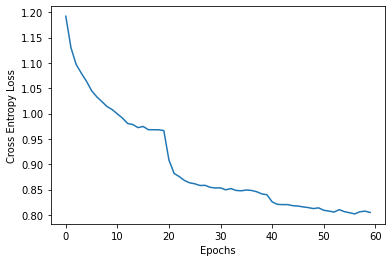

In [ ]:
with open('/content/drive/MyDrive/MiniImageNet/loss_attn_paper_1shot.txt', 'r') as f:
  loss_per_epoch = f.readlines()

loss_per_epoch = [float(x) for x in loss_per_epoch]

plt.plot(loss_per_epoch)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()

## Saving model weights

In [ ]:
torch.save(few_shot_classifier.state_dict(), "/content/drive/MyDrive/MiniImageNet/MiniImagenet/clas_stage2_avg_Paper.pth")

# Evaluating on Validation Sets

In [ ]:
with open("/content/drive/MyDrive/MiniImageNet/MiniImagenet/miniImageNet_category_split_val.pickle", 'rb') as f:
      novel_validation_data = pickle.load(f, encoding='latin1')

In [ ]:
with open("/content/drive/MyDrive/MiniImageNet/MiniImagenet/miniImageNet_category_split_train_phase_val.pickle", 'rb') as f:
      base_validation_data = pickle.load(f, encoding='latin1')

In [ ]:
val_data = MiniImageNet(data_base=base_validation_data, data_novel=novel_validation_data, phase='val')

In [ ]:
# 5-way 5-shot

val_dataloader_5 = FewShotDataloader(
    val_data, 
    nKnovel=5, 
    nKbase=64,
    nExemplars=5, 
    nTestNovel=75, 
    nTestBase=75, 
    batch_size=1, 
    epoch_size=2000
)

In [ ]:
# 5-way 1-shot

val_dataloader_1 = FewShotDataloader(
    val_data, 
    nKnovel=5, 
    nKbase=64,
    nExemplars=1, 
    nTestNovel=75, 
    nTestBase=75, 
    batch_size=1, 
    epoch_size=2000
)

## Feature Averaging

### 5-way 5-shot

In [ ]:
feature_extractor = C128F().to(device)
feature_extractor.load_state_dict(torch.load("/content/drive/MyDrive/MiniImageNet/MiniImagenet/feat.pth"))

<All keys matched successfully>

In [ ]:
few_shot_classifier = Classifier(gen_type="feat_avg").to(device)
few_shot_classifier.load_state_dict(torch.load('/content/drive/MyDrive/MiniImageNet/MiniImagenet/clas_stage2.pth'))

<All keys matched successfully>

In [ ]:
feature_extractor.eval()
acc_both = 0
acc_novel = 0
acc_base = 0
cnt = 0
for Xe,Ye,Xt,Yt,Kall,nKbase in val_dataloader_5():
    Xe = Xe.to(device).view(1 * 25, 3, 84, 84)
    features_train = feature_extractor(Xe)
    features_train = features_train.resize(1,25,3200)
    del Xe

    Xt = Xt.to(device).view(1 * 150, 3, 84, 84)
    features_test = feature_extractor(Xt)
    features_test = features_test.resize(1,150,3200)
    Ye = torch.tensor(Ye).to(device)
    labels_train = []

    for labels in Ye:
      enc = OneHotEncoder()
      labels_train.append(enc.fit_transform(labels.cpu().numpy().reshape(-1,1)).toarray())

    labels_train = torch.tensor(labels_train).to(device)

    output = few_shot_classifier(features_test, features_train.float(), labels_train.float(), Kbase_ids=None, batch_size=1)
    

    Yt = torch.tensor(Yt).to(device).view(1*150)    
    nKbase = nKbase.to(device)

    base_ids = torch.nonzero(Yt < nKbase).view(-1)
    novel_ids = torch.nonzero(Yt >= nKbase).view(-1)
    
    
    output = output.view(150,-1)
    output_base = output[base_ids,:]
    output_novel = output[novel_ids,:]
    Yt_base = Yt[base_ids]
    Yt_novel = Yt[novel_ids]

    

    pred_novel  = nKbase + torch.argmax(output_novel[:,nKbase:], dim=1)
    pred_base = torch.argmax(output_base[:,:nKbase], dim=1)
    pred_both  = torch.argmax(output,dim=1)


    acc_both += skm.accuracy_score(Yt.cpu().detach().numpy(),pred_both.cpu().detach().numpy())
    acc_base += skm.accuracy_score(Yt_base.cpu().detach().numpy(),pred_base.cpu().detach().numpy())
    acc_novel += skm.accuracy_score(Yt_novel.cpu().detach().numpy(),pred_novel.cpu().detach().numpy())
    cnt += 1

print('5-way 5-shot Validation Set Accuracies [Feature Averaging]:\n\tBase Class Accuracy: %f\n\tNovel Class Accuracy: %f\n\tBoth Class Accuracy: %f'%((acc_base/cnt)*100.0, (acc_novel/cnt)*100.0, (acc_both/cnt)*100.0))

5-way 5-shot Validation Set Accuracies [Feature Averaging]:
	Base Class Accuracy: 62.822667
	Novel Class Accuracy: 65.690000
	Both Class Accuracy: 49.749000


### 5-way 1-shot

In [ ]:
few_shot_classifier = Classifier(gen_type="feat_avg").to(device)
few_shot_classifier.load_state_dict(torch.load('/content/drive/MyDrive/MiniImageNet/MiniImagenet/clas_stage2_1shot.pth'))

<All keys matched successfully>

In [ ]:
feature_extractor.eval()
acc_both = 0
acc_novel = 0
acc_base = 0
cnt = 0
for Xe,Ye,Xt,Yt,Kall,nKbase in val_dataloader_1():
    Xe = Xe.to(device).view(1 * 5, 3, 84, 84)
    features_train = feature_extractor(Xe)
    features_train = features_train.resize(1,5,3200)
    del Xe

    Xt = Xt.to(device).view(1 * 150, 3, 84, 84)
    features_test = feature_extractor(Xt)
    features_test = features_test.resize(1,150,3200)
    Ye = torch.tensor(Ye).to(device)
    labels_train = []

    for labels in Ye:
      enc = OneHotEncoder()
      labels_train.append(enc.fit_transform(labels.cpu().numpy().reshape(-1,1)).toarray())

    labels_train = torch.tensor(labels_train).to(device)

    output = few_shot_classifier(features_test, features_train.float(), labels_train.float(), Kbase_ids=None, batch_size=1)
    

    Yt = torch.tensor(Yt).to(device).view(1*150)    
    nKbase = nKbase.to(device)

    base_ids = torch.nonzero(Yt < nKbase).view(-1)
    novel_ids = torch.nonzero(Yt >= nKbase).view(-1)
    
    
    output = output.view(150,-1)
    output_base = output[base_ids,:]
    output_novel = output[novel_ids,:]
    Yt_base = Yt[base_ids]
    Yt_novel = Yt[novel_ids]

    

    pred_novel  = nKbase + torch.argmax(output_novel[:,nKbase:], dim=1)
    pred_base = torch.argmax(output_base[:,:nKbase], dim=1)
    pred_both  = torch.argmax(output,dim=1)


    acc_both += skm.accuracy_score(Yt.cpu().detach().numpy(),pred_both.cpu().detach().numpy())
    acc_base += skm.accuracy_score(Yt_base.cpu().detach().numpy(),pred_base.cpu().detach().numpy())
    acc_novel += skm.accuracy_score(Yt_novel.cpu().detach().numpy(),pred_novel.cpu().detach().numpy())
    cnt += 1

print('5-way 1-shot Accuracies on Validation Set [Feature Averaging]:\n\tBase Class Accuracy: %f\n\tNovel Class Accuracy: %f\n\tBoth Class Accuracy: %f'%((acc_base/cnt)*100.0, (acc_novel/cnt)*100.0, (acc_both/cnt)*100.0))

5-way 1-shot Accuracies on Validation Set [Feature Averaging]:
	Base Class Accuracy: 62.427333
	Novel Class Accuracy: 48.004667
	Both Class Accuracy: 41.031000


## Attention

### 5-way 5-shot

In [ ]:
feature_extractor = C128F().to(device)
feature_extractor.load_state_dict(torch.load("/content/drive/MyDrive/MiniImageNet/MiniImagenet/feat_Paper.pth"))

<All keys matched successfully>

In [ ]:
few_shot_classifier = Classifier(gen_type="attn").to(device)
few_shot_classifier.load_state_dict(torch.load('/content/drive/MyDrive/MiniImageNet/MiniImagenet/clas_stage2_attn_Paper_60.pth'))

<All keys matched successfully>

In [ ]:
feature_extractor.eval()
acc_both = 0
acc_novel = 0
acc_base = 0
cnt = 0
for Xe,Ye,Xt,Yt,Kall,nKbase in val_dataloader_5():
    Xe = Xe.to(device).view(1 * 25, 3, 84, 84)
    features_train = feature_extractor(Xe)
    features_train = features_train.resize(1,25,3200)
    del Xe

    Xt = Xt.to(device).view(1 * 150, 3, 84, 84)
    features_test = feature_extractor(Xt)
    features_test = features_test.resize(1,150,3200)
    Ye = torch.tensor(Ye).to(device)
    labels_train = []

    for labels in Ye:
      enc = OneHotEncoder()
      labels_train.append(enc.fit_transform(labels.cpu().numpy().reshape(-1,1)).toarray())

    labels_train = torch.tensor(labels_train).to(device)

    output = few_shot_classifier(features_test, features_train.float(), labels_train.float(), Kbase_ids=None, batch_size=1)
    

    Yt = torch.tensor(Yt).to(device).view(1*150)    
    nKbase = nKbase.to(device)

    base_ids = torch.nonzero(Yt < nKbase).view(-1)
    novel_ids = torch.nonzero(Yt >= nKbase).view(-1)
    
    
    output = output.view(150,-1)
    output_base = output[base_ids,:]
    output_novel = output[novel_ids,:]
    Yt_base = Yt[base_ids]
    Yt_novel = Yt[novel_ids]

    

    pred_novel  = nKbase + torch.argmax(output_novel[:,nKbase:], dim=1)
    pred_base = torch.argmax(output_base[:,:nKbase], dim=1)
    pred_both  = torch.argmax(output,dim=1)


    acc_both += skm.accuracy_score(Yt.cpu().detach().numpy(),pred_both.cpu().detach().numpy())
    acc_base += skm.accuracy_score(Yt_base.cpu().detach().numpy(),pred_base.cpu().detach().numpy())
    acc_novel += skm.accuracy_score(Yt_novel.cpu().detach().numpy(),pred_novel.cpu().detach().numpy())
    cnt += 1

print('5-way 5-shot Validation Set Accuracies [Attention]:\n\tBase Class Accuracy: %f\n\tNovel Class Accuracy: %f\n\tBoth Class Accuracy: %f'%((acc_base/cnt)*100.0, (acc_novel/cnt)*100.0, (acc_both/cnt)*100.0))

5-way 5-shot Validation Set Accuracies [Attention]:
	Base Class Accuracy: 70.367333
	Novel Class Accuracy: 73.127333
	Both Class Accuracy: 58.022667


### 5-way 1-shot

In [ ]:
few_shot_classifier = Classifier(gen_type="attn").to(device)
few_shot_classifier.load_state_dict(torch.load('/content/drive/MyDrive/MiniImageNet/MiniImagenet/clas_stage2_1shot_paper_attn_60.pth'))

<All keys matched successfully>

In [ ]:
feature_extractor.eval()
acc_both = 0
acc_novel = 0
acc_base = 0
cnt = 0
for Xe,Ye,Xt,Yt,Kall,nKbase in val_dataloader_1():
    Xe = Xe.to(device).view(1 * 5, 3, 84, 84)
    features_train = feature_extractor(Xe)
    features_train = features_train.resize(1,5,3200)
    del Xe

    Xt = Xt.to(device).view(1 * 150, 3, 84, 84)
    features_test = feature_extractor(Xt)
    features_test = features_test.resize(1,150,3200)
    Ye = torch.tensor(Ye).to(device)
    labels_train = []

    for labels in Ye:
      enc = OneHotEncoder()
      labels_train.append(enc.fit_transform(labels.cpu().numpy().reshape(-1,1)).toarray())

    labels_train = torch.tensor(labels_train).to(device)

    output = few_shot_classifier(features_test, features_train.float(), labels_train.float(), Kbase_ids=None, batch_size=1)
    

    Yt = torch.tensor(Yt).to(device).view(1*150)    
    nKbase = nKbase.to(device)

    base_ids = torch.nonzero(Yt < nKbase).view(-1)
    novel_ids = torch.nonzero(Yt >= nKbase).view(-1)
    
    
    output = output.view(150,-1)
    output_base = output[base_ids,:]
    output_novel = output[novel_ids,:]
    Yt_base = Yt[base_ids]
    Yt_novel = Yt[novel_ids]

    

    pred_novel  = nKbase + torch.argmax(output_novel[:,nKbase:], dim=1)
    pred_base = torch.argmax(output_base[:,:nKbase], dim=1)
    pred_both  = torch.argmax(output,dim=1)


    acc_both += skm.accuracy_score(Yt.cpu().detach().numpy(),pred_both.cpu().detach().numpy())
    acc_base += skm.accuracy_score(Yt_base.cpu().detach().numpy(),pred_base.cpu().detach().numpy())
    acc_novel += skm.accuracy_score(Yt_novel.cpu().detach().numpy(),pred_novel.cpu().detach().numpy())
    cnt += 1

print('5-way 1-shot Accuracies on Validation Set [Attention]:\n\tBase Class Accuracy: %f\n\tNovel Class Accuracy: %f\n\tBoth Class Accuracy: %f'%((acc_base/cnt)*100.0, (acc_novel/cnt)*100.0, (acc_both/cnt)*100.0))

5-way 1-shot Accuracies on Validation Set [Attention]:
	Base Class Accuracy: 70.406000
	Novel Class Accuracy: 56.845333
	Both Class Accuracy: 48.548333


# Evaluating on Test Sets

In [ ]:
with open("/content/drive/MyDrive/MiniImageNet/MiniImagenet/miniImageNet_category_split_test.pickle", 'rb') as f:
      novel_test_data = pickle.load(f, encoding='latin1')

In [ ]:
with open("/content/drive/MyDrive/MiniImageNet/MiniImagenet/miniImageNet_category_split_train_phase_test.pickle", 'rb') as f:
      base_test_data = pickle.load(f, encoding='latin1')

In [ ]:
test_data = MiniImageNet(data_base=base_test_data, data_novel=novel_test_data, phase='val')

In [ ]:
# 5-way 5-shot

test_dataloader_5 = FewShotDataloader(
    test_data, 
    nKnovel=5, 
    nKbase=64,
    nExemplars=5, 
    nTestNovel=75, 
    nTestBase=75, 
    batch_size=1, 
    epoch_size=600
)

In [ ]:
# 5-way 1-shot

test_dataloader_1 = FewShotDataloader(
    test_data, 
    nKnovel=5, 
    nKbase=64,
    nExemplars=1, 
    nTestNovel=75, 
    nTestBase=75, 
    batch_size=1, 
    epoch_size=600
)

## Feature Averaging

### 5-way 5-shot

In [ ]:
feature_extractor = C128F().to(device)
feature_extractor.load_state_dict(torch.load("/content/drive/MyDrive/MiniImageNet/MiniImagenet/feat.pth"))

<All keys matched successfully>

In [ ]:
few_shot_classifier = Classifier(gen_type="feat_avg").to(device)
few_shot_classifier.load_state_dict(torch.load('/content/drive/MyDrive/MiniImageNet/MiniImagenet/clas_stage2.pth'))

<All keys matched successfully>

In [ ]:
feature_extractor.eval()
acc_both = 0
acc_novel = 0
acc_base = 0
cnt = 0
for Xe,Ye,Xt,Yt,Kall,nKbase in test_dataloader_5():
    Xe = Xe.to(device).view(1 * 25, 3, 84, 84)
    features_train = feature_extractor(Xe)
    features_train = features_train.resize(1,25,3200)
    del Xe

    Xt = Xt.to(device).view(1 * 150, 3, 84, 84)
    features_test = feature_extractor(Xt)
    features_test = features_test.resize(1,150,3200)
    Ye = torch.tensor(Ye).to(device)
    labels_train = []

    for labels in Ye:
      enc = OneHotEncoder()
      labels_train.append(enc.fit_transform(labels.cpu().numpy().reshape(-1,1)).toarray())

    labels_train = torch.tensor(labels_train).to(device)

    output = few_shot_classifier(features_test, features_train.float(), labels_train.float(), Kbase_ids=None, batch_size=1)
    

    Yt = torch.tensor(Yt).to(device).view(1*150)    
    nKbase = nKbase.to(device)

    base_ids = torch.nonzero(Yt < nKbase).view(-1)
    novel_ids = torch.nonzero(Yt >= nKbase).view(-1)
    
    
    output = output.view(150,-1)
    output_base = output[base_ids,:]
    output_novel = output[novel_ids,:]
    Yt_base = Yt[base_ids]
    Yt_novel = Yt[novel_ids]

    

    pred_novel  = nKbase + torch.argmax(output_novel[:,nKbase:], dim=1)
    pred_base = torch.argmax(output_base[:,:nKbase], dim=1)
    pred_both  = torch.argmax(output,dim=1)


    acc_both += skm.accuracy_score(Yt.cpu().detach().numpy(),pred_both.cpu().detach().numpy())
    acc_base += skm.accuracy_score(Yt_base.cpu().detach().numpy(),pred_base.cpu().detach().numpy())
    acc_novel += skm.accuracy_score(Yt_novel.cpu().detach().numpy(),pred_novel.cpu().detach().numpy())
    cnt += 1

print('5-way 5-shot Test Set Accuracies [Feature Averaging]:\n\tBase Class Accuracy: %f\n\tNovel Class Accuracy: %f\n\tBoth Class Accuracy: %f'%((acc_base/cnt)*100.0, (acc_novel/cnt)*100.0, (acc_both/cnt)*100.0))

5-way 5-shot Test Set Accuracies [Feature Averaging]:
	Base Class Accuracy: 61.564444
	Novel Class Accuracy: 66.744444
	Both Class Accuracy: 50.903333


### 5-way 1-shot

In [ ]:
few_shot_classifier = Classifier(gen_type="feat_avg").to(device)
few_shot_classifier.load_state_dict(torch.load('/content/drive/MyDrive/MiniImageNet/MiniImagenet/clas_stage2_1shot.pth'))

<All keys matched successfully>

In [ ]:
feature_extractor.eval()
acc_both = 0
acc_novel = 0
acc_base = 0
cnt = 0
for Xe,Ye,Xt,Yt,Kall,nKbase in test_dataloader_1():
    Xe = Xe.to(device).view(1 * 5, 3, 84, 84)
    features_train = feature_extractor(Xe)
    features_train = features_train.resize(1,5,3200)
    del Xe

    Xt = Xt.to(device).view(1 * 150, 3, 84, 84)
    features_test = feature_extractor(Xt)
    features_test = features_test.resize(1,150,3200)
    Ye = torch.tensor(Ye).to(device)
    labels_train = []

    for labels in Ye:
      enc = OneHotEncoder()
      labels_train.append(enc.fit_transform(labels.cpu().numpy().reshape(-1,1)).toarray())

    labels_train = torch.tensor(labels_train).to(device)

    output = few_shot_classifier(features_test, features_train.float(), labels_train.float(), Kbase_ids=None, batch_size=1)
    

    Yt = torch.tensor(Yt).to(device).view(1*150)    
    nKbase = nKbase.to(device)

    base_ids = torch.nonzero(Yt < nKbase).view(-1)
    novel_ids = torch.nonzero(Yt >= nKbase).view(-1)
    
    
    output = output.view(150,-1)
    output_base = output[base_ids,:]
    output_novel = output[novel_ids,:]
    Yt_base = Yt[base_ids]
    Yt_novel = Yt[novel_ids]

    

    pred_novel  = nKbase + torch.argmax(output_novel[:,nKbase:], dim=1)
    pred_base = torch.argmax(output_base[:,:nKbase], dim=1)
    pred_both  = torch.argmax(output,dim=1)


    acc_both += skm.accuracy_score(Yt.cpu().detach().numpy(),pred_both.cpu().detach().numpy())
    acc_base += skm.accuracy_score(Yt_base.cpu().detach().numpy(),pred_base.cpu().detach().numpy())
    acc_novel += skm.accuracy_score(Yt_novel.cpu().detach().numpy(),pred_novel.cpu().detach().numpy())
    cnt += 1

print('5-way 1-shot Test Set Accuracies [Feature Averaging]:\n\tBase Class Accuracy: %f\n\tNovel Class Accuracy: %f\n\tBoth Class Accuracy: %f'%((acc_base/cnt)*100.0, (acc_novel/cnt)*100.0, (acc_both/cnt)*100.0))

5-way 1-shot Test Set Accuracies [Feature Averaging]:
	Base Class Accuracy: 61.431111
	Novel Class Accuracy: 50.160000
	Both Class Accuracy: 42.183333


## Attention

### 5-way 5-shot

In [ ]:
feature_extractor = C128F().to(device)
feature_extractor.load_state_dict(torch.load("/content/drive/MyDrive/MiniImageNet/MiniImagenet/feat_Paper.pth"))

<All keys matched successfully>

In [ ]:
few_shot_classifier = Classifier(gen_type="attn").to(device)
few_shot_classifier.load_state_dict(torch.load('/content/drive/MyDrive/MiniImageNet/MiniImagenet/clas_stage2_attn_Paper_60.pth'))

<All keys matched successfully>

In [ ]:
feature_extractor.eval()
acc_both = 0
acc_novel = 0
acc_base = 0
cnt = 0
for Xe,Ye,Xt,Yt,Kall,nKbase in test_dataloader_5():
    Xe = Xe.to(device).view(1 * 25, 3, 84, 84)
    features_train = feature_extractor(Xe)
    features_train = features_train.resize(1,25,3200)
    del Xe

    Xt = Xt.to(device).view(1 * 150, 3, 84, 84)
    features_test = feature_extractor(Xt)
    features_test = features_test.resize(1,150,3200)
    Ye = torch.tensor(Ye).to(device)
    labels_train = []

    for labels in Ye:
      enc = OneHotEncoder()
      labels_train.append(enc.fit_transform(labels.cpu().numpy().reshape(-1,1)).toarray())

    labels_train = torch.tensor(labels_train).to(device)

    output = few_shot_classifier(features_test, features_train.float(), labels_train.float(), Kbase_ids=None, batch_size=1)
    

    Yt = torch.tensor(Yt).to(device).view(1*150)    
    nKbase = nKbase.to(device)

    base_ids = torch.nonzero(Yt < nKbase).view(-1)
    novel_ids = torch.nonzero(Yt >= nKbase).view(-1)
    
    
    output = output.view(150,-1)
    output_base = output[base_ids,:]
    output_novel = output[novel_ids,:]
    Yt_base = Yt[base_ids]
    Yt_novel = Yt[novel_ids]

    

    pred_novel  = nKbase + torch.argmax(output_novel[:,nKbase:], dim=1)
    pred_base = torch.argmax(output_base[:,:nKbase], dim=1)
    pred_both  = torch.argmax(output,dim=1)


    acc_both += skm.accuracy_score(Yt.cpu().detach().numpy(),pred_both.cpu().detach().numpy())
    acc_base += skm.accuracy_score(Yt_base.cpu().detach().numpy(),pred_base.cpu().detach().numpy())
    acc_novel += skm.accuracy_score(Yt_novel.cpu().detach().numpy(),pred_novel.cpu().detach().numpy())
    cnt += 1

print('5-way 5-shot Test Set Accuracies [Attention]:\n\tBase Class Accuracy: %f\n\tNovel Class Accuracy: %f\n\tBoth Class Accuracy: %f'%((acc_base/cnt)*100.0, (acc_novel/cnt)*100.0, (acc_both/cnt)*100.0))

5-way 5-shot Test Set Accuracies [Attention]:
	Base Class Accuracy: 70.128889
	Novel Class Accuracy: 71.248889
	Both Class Accuracy: 56.648889


### 5-way 1-shot

In [ ]:
few_shot_classifier = Classifier(gen_type="attn").to(device)
few_shot_classifier.load_state_dict(torch.load('/content/drive/MyDrive/MiniImageNet/MiniImagenet/clas_stage2_1shot_paper_attn_60.pth'))

<All keys matched successfully>

In [ ]:
feature_extractor.eval()
acc_both = 0
acc_novel = 0
acc_base = 0
cnt = 0
for Xe,Ye,Xt,Yt,Kall,nKbase in test_dataloader_1():
    Xe = Xe.to(device).view(1 * 5, 3, 84, 84)
    features_train = feature_extractor(Xe)
    features_train = features_train.resize(1,5,3200)
    del Xe

    Xt = Xt.to(device).view(1 * 150, 3, 84, 84)
    features_test = feature_extractor(Xt)
    features_test = features_test.resize(1,150,3200)
    Ye = torch.tensor(Ye).to(device)
    labels_train = []

    for labels in Ye:
      enc = OneHotEncoder()
      labels_train.append(enc.fit_transform(labels.cpu().numpy().reshape(-1,1)).toarray())

    labels_train = torch.tensor(labels_train).to(device)

    output = few_shot_classifier(features_test, features_train.float(), labels_train.float(), Kbase_ids=None, batch_size=1)
    

    Yt = torch.tensor(Yt).to(device).view(1*150)    
    nKbase = nKbase.to(device)

    base_ids = torch.nonzero(Yt < nKbase).view(-1)
    novel_ids = torch.nonzero(Yt >= nKbase).view(-1)
    
    
    output = output.view(150,-1)
    output_base = output[base_ids,:]
    output_novel = output[novel_ids,:]
    Yt_base = Yt[base_ids]
    Yt_novel = Yt[novel_ids]

    

    pred_novel  = nKbase + torch.argmax(output_novel[:,nKbase:], dim=1)
    pred_base = torch.argmax(output_base[:,:nKbase], dim=1)
    pred_both  = torch.argmax(output,dim=1)


    acc_both += skm.accuracy_score(Yt.cpu().detach().numpy(),pred_both.cpu().detach().numpy())
    acc_base += skm.accuracy_score(Yt_base.cpu().detach().numpy(),pred_base.cpu().detach().numpy())
    acc_novel += skm.accuracy_score(Yt_novel.cpu().detach().numpy(),pred_novel.cpu().detach().numpy())
    cnt += 1

print('5-way 1-shot Test Set Accuracies [Attention]:\n\tBase Class Accuracy: %f\n\tNovel Class Accuracy: %f\n\tBoth Class Accuracy: %f'%((acc_base/cnt)*100.0, (acc_novel/cnt)*100.0, (acc_both/cnt)*100.0))

5-way 1-shot Test Set Accuracies [Attention]:
	Base Class Accuracy: 70.004444
	Novel Class Accuracy: 54.824444
	Both Class Accuracy: 47.465556
